In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('quiqua.csv', sep=";")

In [3]:
df.head()

,Renda,Estado,Escolaridade,Anos_Estudo,Estado_Civil,Gasto
0,5948,MG,Superior,9,Solteiro,3000
1,5870,MG,Superior,8,Solteiro,2600
2,5710,GO,Superior,9,Casado,2700
3,5660,RJ,Médio,7,Casado,3100
4,5351,SP,Superior,8,Solteiro,2000


# Frequencias

In [4]:
#Absoluta
pd.value_counts(df['Estado'])

SP    5
MG    4
RJ    4
TO    3
GO    3
RS    2
Name: Estado, dtype: int64

In [5]:
#Relativa
(pd.value_counts(df['Estado'])/len(df))

SP    0.238095
MG    0.190476
RJ    0.190476
TO    0.142857
GO    0.142857
RS    0.095238
Name: Estado, dtype: float64

In [6]:
pd.crosstab(df['Estado'],df['Escolaridade']).apply(lambda r: r/r.sum(), axis=1) #total por colunas

Escolaridade,Fundamental,Médio,Superior
Estado,,,
GO,0.666667,0.000000,0.333333
MG,0.500000,0.000000,0.500000
RJ,0.500000,0.500000,0.000000
RS,0.500000,0.000000,0.500000
SP,0.000000,0.800000,0.200000
TO,0.333333,0.333333,0.333333


In [7]:
pd.crosstab(df['Estado'],df['Escolaridade']).apply(lambda r: r/r.sum(), axis=0) #total por linhas

Escolaridade,Fundamental,Médio,Superior
Estado,,,
GO,0.250,0.000000,0.166667
MG,0.250,0.000000,0.333333
RJ,0.250,0.285714,0.000000
RS,0.125,0.000000,0.166667
SP,0.000,0.571429,0.166667
TO,0.125,0.142857,0.166667


# Medidas - Univariado

In [8]:
import statistics as st
print(df['Renda'].mean()) #calculo da média
print(st.median(df['Renda'])) #mediana
print(st.stdev(df['Renda'])) #desvio-padrao amostral
print(st.stdev(df['Renda'])/df['Renda'].mean()) #coeficiente de variacao - desvio padrao dividido pela media

3852.5238095238096
4454
1751.1335648387196
0.45454191886102013


In [9]:
df['Renda'].quantile([.1,.5,.75,0.9]) #quantis

0.10    1452.0
0.50    4454.0
0.75    5312.0
0.90    5710.0
Name: Renda, dtype: float64

In [10]:
np.average(df['Renda'], weights=df['Anos_Estudo']) #média de renda ponderada por anos de estudo

4559.628318584071

In [57]:
print(df['Gasto'].skew()) #medida de assimetria

0.644278311823383


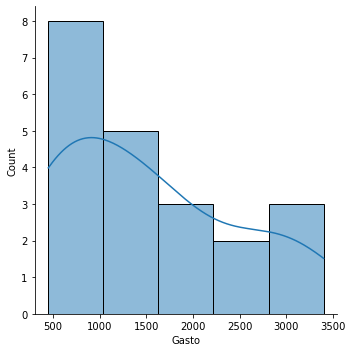

In [60]:
sns.displot(df["Gasto"], bins=5, kde=True)

In [54]:
df['Renda'].kurtosis() #medida de curtose

-1.5005089035133707

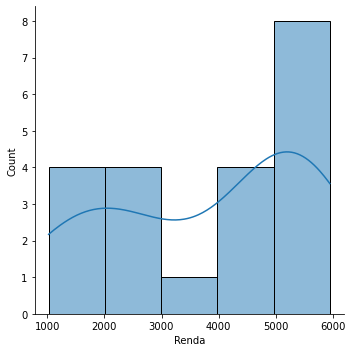

In [62]:
sns.displot(df["Renda"], bins=5, kde=True)

# Medidas - Multivariado

In [11]:
#Correlação de spearman entre colunas quantitativas
df[['Renda','Anos_Estudo']].corr('spearman')

,Renda,Anos_Estudo
Renda,1.000000,0.927955
Anos_Estudo,0.927955,1.000000


In [12]:
from scipy.stats import chi2_contingency

In [13]:
#Calcular qui-quadrado e vcramer, medidas de associação entre variáveis categóricas. Quanto maior o vcramer, maior a associação
# entre as variáveis
CATVAR = df.select_dtypes(include=['object']).columns.tolist() #cria uma lista das variaveis categoricas
chimap = pd.DataFrame(columns=['Var1','Var2','xsq','pvalue','vcramer']) #cria dataframe para inserir valores do chisquare
for x in CATVAR:
    for y in CATVAR:
        if x != y:
            chi = df.pivot_table('Renda',index= [x],columns= [y] ,aggfunc = 'count')
            chi=chi.replace(np.nan,0)
            xsq,pvalue,dof,expected=chi2_contingency(chi)
            a = min(len(df[x].unique()),len(df[y].unique()))
            b = len(df[x])
            vcramer = (xsq/(b*(a-1)))**(1/2)
            chimap = chimap.append({'Var1' : x, 'Var2' : y, 'xsq': xsq, 'pvalue': pvalue, 'vcramer':vcramer}, ignore_index=True)
chimap = chimap.sort_values(by = 'vcramer', ascending = False)
chimap

,Var1,Var2,xsq,pvalue,vcramer
1,Estado,Estado_Civil,14.986364,0.010421,0.844770
4,Estado_Civil,Estado,14.986364,0.010421,0.844770
0,Estado,Escolaridade,11.820833,0.297226,0.530517
2,Escolaridade,Estado,11.820833,0.297226,0.530517
3,Escolaridade,Estado_Civil,1.742045,0.418523,0.288018
5,Estado_Civil,Escolaridade,1.742045,0.418523,0.288018


In [14]:
CATVAR = df.select_dtypes(include=['object']).columns.tolist()
NUMVAR = df.select_dtypes(include=['float64','int64']).columns.tolist()

In [15]:
#Calculo do R2 - Medida de associação entre uma variável quantitativa e qualitativa
#R2 alto e positivo significa uma correlação positiva entre as variáveis. R2 alto e negativo significa uma correlaçao negativa

In [16]:
r2 = pd.DataFrame(columns=['VarQuanti','VarQuali','var*n / n_total','R2'])
for z in NUMVAR:
    for x in CATVAR:
        dfr = df[x].value_counts().reset_index()
        f = 0
        a1 = 0
        for y in range(len(dfr)):
            a = dfr.iloc[y,1]
            a1 = a1 + a
            c = (df[df[x] == dfr.iloc[y,0]])
            e = (c[z].var())*a
            f = f + e
        f = f/a1
        r2_calc = 1 - (f/df[z].var())
        r2 = r2.append({'VarQuanti' : z, 'VarQuali' : x,'var*n / n_total' : f, 'R2' : r2_calc}, ignore_index=True)
r2 = r2.sort_values(by = 'R2', ascending = False)
r2

,VarQuanti,VarQuali,var*n / n_total,R2
1,Renda,Escolaridade,1.279860e+06,0.582627
4,Anos_Estudo,Escolaridade,3.138322e+00,0.497677
7,Gasto,Escolaridade,6.843639e+05,0.257807
6,Gasto,Estado,9.251190e+05,-0.003292
8,Gasto,Estado_Civil,9.353466e+05,-0.014384
5,Anos_Estudo,Estado_Civil,6.492063e+00,-0.039126
2,Renda,Estado_Civil,3.211468e+06,-0.047285
3,Anos_Estudo,Estado,7.436508e+00,-0.190295
0,Renda,Estado,3.937980e+06,-0.284207


# Tabelas Cruzadas

In [17]:
df.pivot_table('Renda',index=["Estado","Estado_Civil"], aggfunc='mean',margins=True) 
#media da renda por estado e estado_civil

Renda
Estado Estado_Civil             
GO     Casado        3327.333333
MG     Casado        4950.000000
       Solteiro      4323.333333
RJ     Casado        5660.000000
       Solteiro      3202.333333
RS     Casado        3401.000000
SP     Solteiro      4223.600000
TO     Casado        3271.333333
All                  3852.523810

In [18]:
df.pivot_table('Renda',index=["Estado"],columns=['Escolaridade'], aggfunc='count',margins=True) 
#quantas observacoes por estado e escolaridade, se colocar dropna = True, exclui os NaN

Escolaridade,Fundamental,Médio,Superior,All
Estado,,,,
GO,2.0,NaN,1.0,3
MG,2.0,NaN,2.0,4
RJ,2.0,2.0,NaN,4
RS,1.0,NaN,1.0,2
SP,NaN,4.0,1.0,5
TO,1.0,1.0,1.0,3
All,8.0,7.0,6.0,21


In [19]:
df.pivot_table('Renda',index=["Estado","Estado_Civil"], columns=['Escolaridade'] ,aggfunc='mean',margins=True)
#media da renda por estado, estado_civil e escolaridade

Escolaridade         Fundamental        Médio     Superior          All
Estado Estado_Civil                                                    
GO     Casado           2136.000          NaN  5710.000000  3327.333333
MG     Casado           4950.000          NaN          NaN  4950.000000
       Solteiro         1152.000          NaN  5909.000000  4323.333333
RJ     Casado                NaN  5660.000000          NaN  5660.000000
       Solteiro         2420.000  4767.000000          NaN  3202.333333
RS     Casado           1494.000          NaN  5308.000000  3401.000000
SP     Solteiro              NaN  3941.750000  5351.000000  4223.600000
TO     Casado           1023.000  4454.000000  4337.000000  3271.333333
All                     2216.375  4378.285714  5420.666667  3852.523810

In [20]:
#transformando a tabela cruzada em df, usando reset.index()
df2 = (df.pivot_table('Renda',index=["Estado","Estado_Civil"], columns=['Escolaridade'] ,aggfunc='mean',margins=True)).reset_index()

In [21]:
df2

Escolaridade,Estado,Estado_Civil,Fundamental,Médio,Superior,All
0,GO,Casado,2136.000,NaN,5710.000000,3327.333333
1,MG,Casado,4950.000,NaN,NaN,4950.000000
2,MG,Solteiro,1152.000,NaN,5909.000000,4323.333333
3,RJ,Casado,NaN,5660.000000,NaN,5660.000000
4,RJ,Solteiro,2420.000,4767.000000,NaN,3202.333333
5,RS,Casado,1494.000,NaN,5308.000000,3401.000000
6,SP,Solteiro,NaN,3941.750000,5351.000000,4223.600000
7,TO,Casado,1023.000,4454.000000,4337.000000,3271.333333
8,All,,2216.375,4378.285714,5420.666667,3852.523810
